In [14]:
import os
import pandas as pd
import numpy as np
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [15]:
data_path_local = "/Users/mateuszjenek/Desktop/PDB/ratings_Beauty.csv"
data_path_remote = "https://github.com/mateuszjenek/Recommedation-algorithm/raw/main/ratings_Beauty.csv"

In [16]:
df = pd.read_csv(data_path_remote)
usecols = ["UserId", "ProductId", "Rating"],
dtype = {"UserId": "str", "ProductId": "int32", "Rating": "float32"}

df = df[:50000]
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [17]:
df_products_features = df.pivot(
    index="UserId",
    columns="ProductId",
    values="Rating"
).fillna(0)

df_products_features

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,130414674X,1304168522,1304174778,1304174867,1304174905,1304196046,1304196062,1304196070,1304196135,1304351475,1304482596,1304482634,1304482685,1304488608,1304495396,1304511073,1304511081,1304511111,130451112X,1304511138,1304511146,1304511154,1304622193,1304622223,1304622428,1304622452,1304622460,1304622622,1304622657,1304622665,...,B00012URGE,B00012URN2,B00012URS2,B00012URW8,B00012URZU,B00012US9U,B00012USPO,B00012USZE,B00012UTXK,B00012WYH4,B00012WYHY,B00012WYI8,B00012WYKQ,B000132G7G,B000136P7S,B00013899A,B00013A038,B00013EWR8,B00013J7H8,B00013MSYC,B00013MSYW,B00013MT1O,B00013MT32,B00013MT3M,B00013MT46,B00013MT6O,B00013MT7I,B00013MT96,B00013MT9G,B00013MTA0,B00013TQRE,B00013UHBS,B00013V0A0,B00013V0AU,B00013YYS0,B00013YZ7U,B00013YZCA,B00013YZRU,B00013YZS4,B00013Z0CE
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00473363TJ8YSZ3YAGG9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01437583CZ7V02UKZQ5S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01456542S5QPYUEGJXR8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01907982I6OHXDYN5HD6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZQXL8VDCFTV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZSAMMJPJKJ1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZTJQ7CQZUD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [18]:
num_users = len(df.UserId.unique())
num_items = len(df.ProductId.unique())
print("There are {} unique users and {} unique products in this data set".format(num_users, num_items))  # TODO: Formmated string

There are 47017 unique users and 2581 unique products in this data set


In [19]:
df_ratings = pd.DataFrame(df.groupby("Rating").size(), columns=["count"])
df_ratings

,count
Rating,
1.0,4722
2.0,2713
3.0,3838
4.0,7324
5.0,31403


Text(0, 0.5, 'number of ratings')

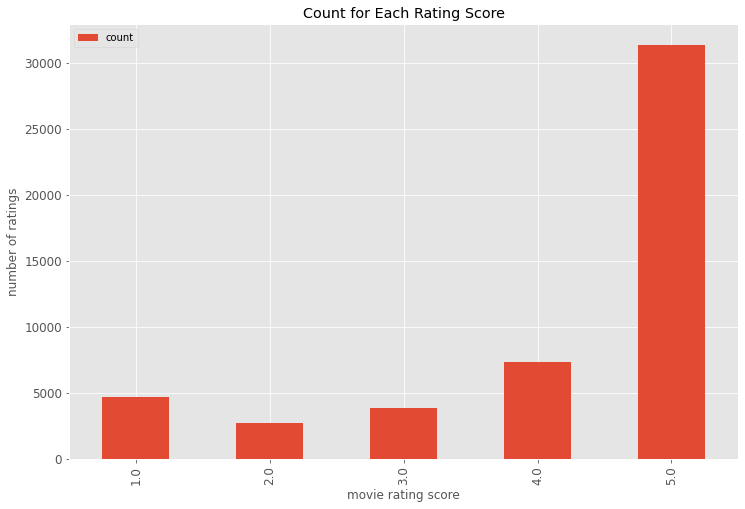

In [20]:
plt.style.use("ggplot")
get_ipython().run_line_magic("matplotlib", "inline")
ax = df_ratings[["count"]].reset_index().plot(
    x="Rating",
    y="count",
    kind="bar",
    figsize=(12, 8),
    title="Count for Each Rating Score",
    logy=False,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [21]:
df_products_cnt = pd.DataFrame(df.groupby(
    "ProductId").size(), columns=["count"])
df_products_cnt = df_products_cnt.sort_values("count", ascending=False)
df_products_cnt.head()

,count
ProductId,
B0000YUXI0,2143
B00006IV2F,704
B0000632EN,686
B0000CC64W,590
B00005O0MZ,585


In [80]:
popularity_thres = 20
popular_products = list(set(df_products_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_products = df[df.ProductId.isin(popular_products)]
print('shape of original ratings data: ', df.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_products.shape)

shape of original ratings data:  (50000, 4)
shape of ratings data after dropping unpopular movies:  (41312, 4)


In [94]:
df_users_cnt = pd.DataFrame(df_ratings_drop_products.groupby('UserId').size(), columns=['count'])
df_users_cnt = df_users_cnt.sort_values("count", ascending=False)
df_users_cnt.head(10)

,count
UserId,
A281NPSIMI1C2R,22
AKMEY1BSHSDG7,11
A3M174IC0VXOS2,10
A132ETQPMHQ585,8
A1IU7S4HCK1XK0,7
A2Y4S4CNGKF21S,7
A13IRKEEPFTWFM,6
AK7CAW3N1XZV6,6
A2VOGNBUMXSW13,6


In [82]:
ratings_thres = 2
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_products[df_ratings_drop_products.UserId.isin(active_users)]
print('shape of original ratings data: ', df_ratings_drop_products.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ',
df_ratings_drop_users.shape)

shape of original ratings data:  (41312, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (4079, 4)


In [90]:
product_user_mat = df_ratings_drop_users.pivot(index='ProductId', columns='UserId', values='Rating').fillna(0)
product_user_mat_sparse = csr_matrix(product_user_mat.values)
product_to_idx = {
  product:i for i, product in enumerate(product_user_mat.index)
}
idx_to_product = {
  i:product for i, product in enumerate(product_user_mat.index)
}
print(product_user_mat.head(9))

UserId      A103D23F4SGCJY  A105TOJ6LTVMBG  ...  AZWXG6KBXXC2N  AZZNK89PXD006
ProductId                                   ...                              
3227001381             0.0             0.0  ...            0.0            0.0
7806397051             0.0             0.0  ...            0.0            0.0
9746427962             0.0             0.0  ...            0.0            0.0
9759091062             0.0             0.0  ...            0.0            0.0
9788071198             0.0             0.0  ...            0.0            0.0
9788072216             0.0             0.0  ...            0.0            0.0
9788073409             0.0             0.0  ...            0.0            0.0
9788073840             0.0             0.0  ...            0.0            0.0
9790778309             0.0             0.0  ...            0.0            0.0

[9 rows x 2066 columns]


In [65]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [88]:
def make_recommendation(model_knn, data, fav_product_id, n_recommendations):
  model_knn.fit(data)
  print('You have input product:', fav_product_id)
  print('Recommendation system start to make inference')
  print('......\n')
  idx = product_to_idx[fav_product_id]
  distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
  raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
  print('Recommendations for {}:'.format(fav_product_id))
  for i, (idx, dist) in enumerate(raw_recommends):
    print('{0}: {1}, with distance of {2}'.format(i+1, idx_to_product[idx], dist))

In [91]:
my_favorite_product_id = "B0000YUXI0"
make_recommendation(
  model_knn = model_knn,
  data = product_user_mat_sparse,
  fav_product_id = my_favorite_product_id,
  n_recommendations = 10)

You have input product: B0000YUXI0
Recommendation system start to make inference
......

Recommendations for B0000YUXI0:
1: B0000632EE, with distance of 0.9340364800875132
2: B0000Y3GAC, with distance of 0.9242532916200472
3: B000052YKS, with distance of 0.9229125378265675
4: B00006JN4F, with distance of 0.9223628876413709
5: B0000AFUTL, with distance of 0.9144226960019515
6: B0000682T7, with distance of 0.9122320633817849
7: B0000536EK, with distance of 0.9109870659260473
8: B0000UTUS8, with distance of 0.8942546452755403
9: B00006FDU6, with distance of 0.8741167014059938
10: B00011QVIS, with distance of 0.8065120055575943
